#### [00] Importing Data

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks 
from imblearn.under_sampling import EditedNearestNeighbours 

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE 

**!! Edit kdPIC parameter**

specify the "kdPIC" and the band that would be calculated

In [2]:
kdPIC = "F"

#### [01] Under dan Over Sampling Function Definition

In [39]:
standard_=['B1_p15','B2_p15','B3_p15','B4_p15','B5_p15','B6_p15','B7_p15',
          'B8_p15','B8A_p15','B11_p15','B12_p15','NDVI_p50','NDWI_p50','NDBI_p50','SAVI_p50',
          'EVI_p50','GNDVI_p50']

def ratio_multiplier(y):
    from collections import Counter

    multiplier = strategy_under2
    target_stats = Counter(y)
    for key, value in target_stats.items():
        if key in multiplier:
            target_stats[key] = int(value * multiplier[key])
    return target_stats

def finalise(X,y):
    res = X.copy()
    res['nama_valid'] = y
    return res

def create_dataset(name_file):
    global df_sample
    global X_res_tl_s
    
    
    gs_folder = "gs://bps-gcp-bucket/MLST2023/preprocessing/"
    df_sample = pd.read_csv(gs_folder+name_file)
    
    y = df_sample.nama_valid
    X = df_sample[['B1_p15', 'B2_p15', 'B3_p15',
           'B4_p15', 'B5_p15', 'B6_p15', 'B7_p15', 'B8_p15', 'B8A_p15', 'B11_p15',
           'B12_p15', 'NDVI_p50', 'NDWI_p50', 'NDBI_p50', 'SAVI_p50', 'EVI_p50',
           'GNDVI_p50']]

    n = df_sample.groupby("nama_valid").nama_valid.count()
    ntmp = y.value_counts().median()
    nmean=int(0.8*ntmp)
    
    up_=n[n>int(1.3*nmean)]
    under_=n[n<int(0.7*nmean)]
    another_=n[(n<int(1.3*nmean))&(n>int(0.7*nmean))]
    
    strategy_upper = dict(zip(under_.index, [int(0.7*nmean)]*len(under_)))
    strategy_under = dict(zip(up_.index, [int(1.3*nmean)]*len(under_)))
    strategy_ = dict(zip(another_.index, another_))


    tl_ = TomekLinks('majority')
    enn_ = EditedNearestNeighbours('majority')
    rus_ = RandomUnderSampler(sampling_strategy=strategy_under)

    X_tl, y_tl = tl_.fit_resample(X, y)
    X_enn, y_enn = enn_.fit_resample(X, y)

    X_res_tl, y_res_tl = rus_.fit_resample(X_tl, y_tl)
    X_res_enn, y_res_enn = rus_.fit_resample(X_enn, y_enn)

    smote_ = SMOTE(sampling_strategy=strategy_upper)
    B_smote_ = BorderlineSMOTE(sampling_strategy=strategy_upper)

    X_res_tl_s, y_res_tl_s = smote_.fit_resample(X_res_tl, y_res_tl)
    X_res_enn_s, y_res_enn_s = smote_.fit_resample(X_res_enn, y_res_enn)

    X_res_tl_bs, y_res_tl_bs = B_smote_.fit_resample(X_res_tl, y_res_tl)
    X_res_enn_bs, y_res_enn_bs = B_smote_.fit_resample(X_res_enn, y_res_enn)
  
    finalise(X_res_tl_s, y_res_tl_s).to_csv(gs_folder+name_file[:-4]+"_tl_smote.csv", index=False)
    finalise(X_res_tl_bs, y_res_tl_bs).to_csv(gs_folder+name_file[:-4]+"_tl_border_smote.csv", index=False)
    finalise(X_res_enn_s, y_res_enn_s).to_csv(gs_folder+name_file[:-4]+"_enn_smote.csv", index=False)
    finalise(X_res_enn_bs, y_res_enn_bs).to_csv(gs_folder+name_file[:-4]+"_enn_border_smote.csv", index=False)
    
    df_sample['ket'] = 'asli'
    X_res_tl_s['ket'] = 'sintetik'
    X_res_tl_s['nama_valid'] = y_res_tl_s

#### [02] Running Under dan Over Sampling

In [40]:
name_file = ["sample_"+kdPIC+".csv"]
#             "sample_"+kdPIC+"_no_outlier.csv"]
for i in name_file: 
    create_dataset(i)
    df_all = df_sample
    df_all = df_all.append(X_res_tl_s)
    

/home/jupyter-peta_admin/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/tmp/ipykernel_5149/1256782486.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(X_res_tl_s)


#### [03] Perbandingan Jumlah Landamark per Kategori

In [48]:
X_res_tl_s.groupby("nama_valid").count()

,B1_p15,B2_p15,B3_p15,B4_p15,B5_p15,B6_p15,B7_p15,B8_p15,B8A_p15,B11_p15,B12_p15,NDVI_p50,NDWI_p50,NDBI_p50,SAVI_p50,EVI_p50,GNDVI_p50,ket
nama_valid,,,,,,,,,,,,,,,,,,
100101,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652
100102,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652
100107,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652
100108,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652
100201,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652
100202,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889
100203,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207,1207
100204,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889,889
100205,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126,17126


[]

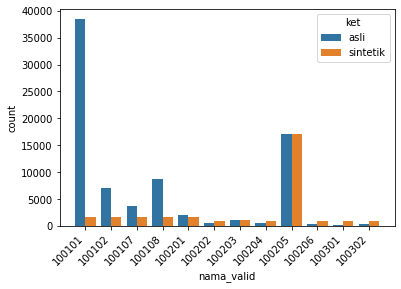

In [44]:
sns.countplot(x='nama_valid',hue='ket',data=df_all)
plt.xticks(rotation=45, ha='right')
plt.plot()

In [37]:
df_all.loc[df_all.ket == 'sintetik']

,ID_GRID,kdPIC,nama_valid,B1_p15,B2_p15,B3_p15,B4_p15,B5_p15,B6_p15,B7_p15,...,cen_x,cen_y,mahalo_dist,flag_out_mahalanobis,dbscan_out,flag_out_dbscan,isofor_out,flag_out_isolation,outlier_detect,ket
0,NaN,NaN,NaN,0.125100,0.096879,0.088718,0.064428,0.085158,0.132660,0.158030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
1,NaN,NaN,NaN,0.120950,0.095583,0.089159,0.062799,0.098509,0.174004,0.203433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
2,NaN,NaN,NaN,0.156467,0.111053,0.107749,0.078914,0.118298,0.184975,0.211233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
3,NaN,NaN,NaN,0.123100,0.093921,0.090242,0.059069,0.093563,0.187814,0.243458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
4,NaN,NaN,NaN,0.123987,0.097026,0.091858,0.063549,0.093057,0.175270,0.207088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31033,NaN,NaN,NaN,0.128840,0.100000,0.082361,0.055831,0.060206,0.073743,0.085377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
31034,NaN,NaN,NaN,0.127622,0.104934,0.091436,0.064509,0.067478,0.046415,0.049198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
31035,NaN,NaN,NaN,0.134182,0.113909,0.100564,0.066268,0.062822,0.058615,0.066677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik
31036,NaN,NaN,NaN,0.153439,0.162043,0.133321,0.050019,0.038073,0.030400,0.030366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sintetik


In [36]:
sns.countplot(x='nama_valid',data=df_all.loc[df_all.ket == 'sintetik'])

ValueError: min() arg is an empty sequence